In [1]:
import networkx as nx
import sys
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math

## 1. Where is SN100?

In [2]:
graph = nx.Graph(nx.read_pajek("data/dolphins.net"))
node_neigbours = sorted(graph.degree(), key = lambda x: x[1], reverse=True)[:3]
degree_centrality = sorted(nx.degree_centrality(graph).items(), key=lambda x : x[1], reverse=True)[:3]
betweenness_centrality = sorted(nx.betweenness_centrality(graph).items(), key=lambda x : x[1], reverse=True)[:3]
closeness_centrality = sorted(nx.closeness_centrality(graph).items(), key=lambda x : x[1], reverse=True)[:3]
load_centrality = sorted(nx.load_centrality(graph).items(), key=lambda x : x[1], reverse=True)[:3]
print('Neigbours:', node_neigbours)
print('Degree centrality:', degree_centrality)
print('Betweenness centrality:', betweenness_centrality)
print('Closeness centrality:', closeness_centrality)
print('Load centrality:', load_centrality)

Neigbours: [('Grin', 12), ('SN4', 11), ('Topless', 11)]
Degree centrality: [('Grin', 0.19672131147540983), ('SN4', 0.18032786885245902), ('Topless', 0.18032786885245902)]
Betweenness centrality: [('SN100', 0.24823719602893804), ('Beescratch', 0.21332443553281097), ('SN9', 0.1431495183426175)]
Closeness centrality: [('SN100', 0.4178082191780822), ('SN9', 0.40397350993377484), ('SN4', 0.39869281045751637)]
Load centrality: [('SN100', 0.24014528580102343), ('Beescratch', 0.19919624786769607), ('SN9', 0.14959271908520544)]


## 2. Is software scale-free?

In [3]:
def get_all_degrees(G):
    degrees = np.array(G.degree())[:, 1].astype('int')
    in_degrees = np.array(G.in_degree())[:, 1].astype('int')
    out_degrees = np.array(G.out_degree())[:, 1].astype('int')
    k, count = np.unique(degrees, return_counts=True)
    in_k, in_count = np.unique(in_degrees, return_counts=True)
    out_k, out_count = np.unique(out_degrees, return_counts=True)
    return [degrees, in_degrees, out_degrees], [k, in_k, out_k], [count, in_count, out_count]

def calculate_gamma(degrees, kmin):
    cutoff_degrees = degrees[degrees >= kmin]
    gamma = 1 + len(cutoff_degrees)/np.sum(np.log(cutoff_degrees/(kmin-0.5)))
    return gamma

def plot_degree_distributions(G, k, count, name):
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.loglog(k[0], count[0]/len(G), 'o', label=name+" degrees")
    plt.loglog(k[1], count[1]/len(G), 'o', label=name+" in degrees")
    plt.loglog(k[2], count[2]/len(G), 'o', label=name+" out degrees")
    plt.ylabel('$log(p_k)$')
    plt.xlabel('$log(k)$')
    plt.title(name+' degree distributions')
    plt.legend()
    plt.savefig(name+' degree distributions.png', bbox_inches='tight')

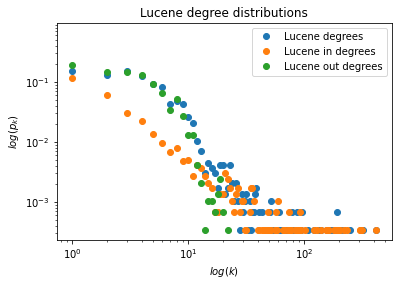

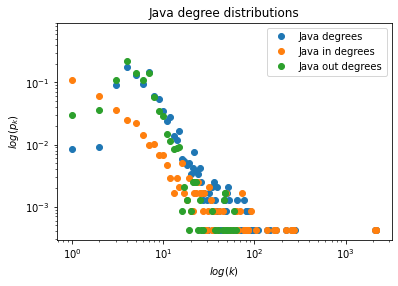

In [4]:
lucene_G = nx.DiGraph(nx.read_pajek("data/lucene.net"))
java_G = nx.DiGraph(nx.read_pajek("data/java.net"))

lucene_degrees, lucene_k, lucene_count = get_all_degrees(lucene_G)
java_degrees, java_k, java_count = get_all_degrees(java_G)

plot_degree_distributions(lucene_G, lucene_k, lucene_count, 'Lucene')
plot_degree_distributions(java_G, java_k, java_count, 'Java')

In [5]:
kmin = 3
print('Lucene degrees gamma:', calculate_gamma(lucene_degrees[0], kmin))
print('Lucene in degrees gamma:', calculate_gamma(lucene_degrees[1], kmin))
print('Lucene out degrees gamma:', calculate_gamma(lucene_degrees[2], kmin))
print('Java degrees gamma:', calculate_gamma(java_degrees[0], kmin))
print('Java in degrees gamma:', calculate_gamma(java_degrees[1], kmin))
print('Java out degrees gamma:', calculate_gamma(java_degrees[2], kmin))

Lucene degrees gamma: 2.1168824976508187
Lucene in degrees gamma: 1.7502527415702178
Lucene out degrees gamma: 2.464044135451709
Java degrees gamma: 1.9630205996242844
Java in degrees gamma: 1.7789243052864685
Java out degrees gamma: 2.210294495567659


## 3. Errors and attacks on the Internet

In [6]:
def erdos_renyi(n, m):
    G = nx.MultiGraph(name="erdos_renyi")
    for i in range(n):
        G.add_node(i)
    edges = []
    while len(edges) < m:
        i = random.randint(0, n - 1)
        j = random.randint(0, n - 1)
        if i != j:
            edges.append((i, j))
    G.add_edges_from(edges)
    return G

def random_attack(graph, p):
    G = graph.copy()
    attack_nodes = random.sample(G.nodes(), int(len(G)*p))
    G.remove_nodes_from(attack_nodes)
    biggest_component = sorted(nx.connected_components(G), key=len, reverse=True)[0]
    fraction = len(biggest_component)/len(G)
    return G, fraction

def malicious_attack(graph, p):
    G = graph.copy()
    degrees = np.array(G.degree())
    attack_nodes_i = np.argsort(degrees[:, 1].astype('int'))[-int(len(G)*0.1):]
    attack_nodes = degrees[attack_nodes_i][:, 0]
    G.remove_nodes_from(attack_nodes)
    biggest_component = sorted(nx.connected_components(G), key=len, reverse=True)[0]
    fraction = len(biggest_component)/len(G)
    return G, fraction

def attack(G, func, p, n_iter=5):
    fractions = [1.0]
    for i in range(n_iter):
        G, fraction = func(G, p)
        fractions.append(fraction)
    return fractions

def plot_attack(G, graph_name):
    x = list(range(0, 60, 10))
    y1 = attack(G, random_attack, 0.1)
    y2 = attack(G, malicious_attack, 0.1)
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.plot(x, y1, label="Random attack", marker='x')
    plt.plot(x, y2, label="Malicious attack", marker='x')
    plt.ylabel('Fraction of nodes in LCC')
    plt.xlabel('Percentage of removed nodes')
    plt.legend()
    plt.savefig(graph_name+' attacks.png')

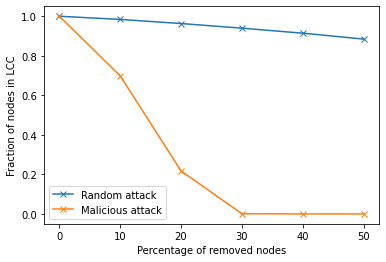

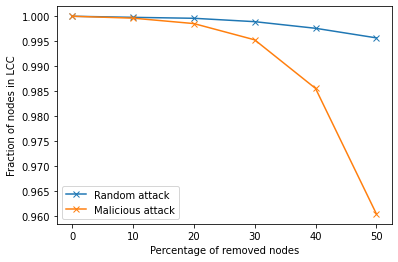

In [7]:
internet_G = nx.Graph(nx.read_pajek("data/nec.net"))
random_G = erdos_renyi(len(internet_G), len(internet_G.edges()))

plot_attack(internet_G, 'Internet')
plot_attack(random_G, 'Erdos Renyi')

## 4.  HIV and network sampling

In [8]:
def random_sample_graph(G, size):
    sample_G = nx.Graph()
    nodes = list(G.nodes())
    node = random.sample(nodes, 1)[0]
    sample_G.add_node(node)
    while len(sample_G) < size:
        edges = list(G.edges(node))
        if len(edges) > 0:
            node_from, node_to = random.sample(edges, 1)[0]
            sample_G.add_edge(node_from, node_to)
            node = node_to            
        else:
            node = random.sample(nodes, 1)[0]          
    return sample_G

def info(G, degrees, kmin = 5, fast = False):
    print("{:>12s} | '{:s}'".format('Graph', G.name))
    n = G.number_of_nodes()
    m = G.number_of_edges()
    d = 2 * m / n
    print("{:>12s} | {:.2f} ({:,d})".format('Avg degree', d, max([k for _, k in G.degree()])))
    print("{:>12s} | {:.2f} ({:d})".format('Gamma', calculate_gamma(degrees, kmin), kmin))

    if not fast:
        if isinstance(G, nx.DiGraph):
            G = nx.MultiGraph(G)
        
        D = nx.average_shortest_path_length(G)
        print("{:>12s} | {:.1f}".format('Avg distance 1', D))
        print("{:>12s} | {:.1f}".format('Avg distance 2', math.log(n)/math.log(d)))
        
        if isinstance(G, nx.MultiGraph):
            G = nx.Graph(G)
        print("{:>12s} | {:.4f}".format('Clustering', nx.average_clustering(G)))
    print()

In [9]:
social_G = nx.Graph(nx.read_pajek("data/social.net"))
size = int(len(social_G)*0.1)
sampled_G = random_sample_graph(social_G, size)

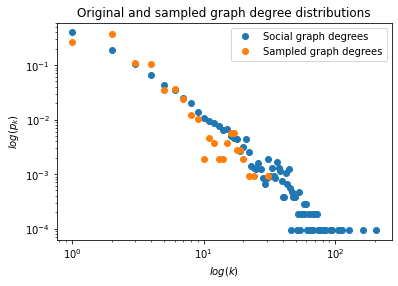

In [10]:
social_degrees = np.array(social_G.degree())[:, 1].astype('int')
social_k, social_count = np.unique(social_degrees, return_counts=True)
sampled_degrees = np.array(sampled_G.degree())[:, 1].astype('int')
sampled_k, sampled_count = np.unique(sampled_degrees, return_counts=True)
fig = plt.figure()
ax = fig.add_subplot()
plt.loglog(social_k, social_count/len(social_G), 'o', label="Social graph degrees")
plt.loglog(sampled_k, sampled_count/len(sampled_G), 'o', label="Sampled graph degrees")
plt.ylabel('$log(p_k)$')
plt.xlabel('$log(k)$')
plt.title('Original and sampled graph degree distributions')
plt.legend()
plt.savefig('Social graph degree distributions.png')

In [11]:
kmin = 3
social_G.name = "Social"
sampled_G.name = "Sampled"
info(social_G, social_degrees, kmin, False)
info(sampled_G, sampled_degrees, kmin, False)

       Graph | 'Social'
  Avg degree | 4.55 (205)
       Gamma | 2.06 (3)
Avg distance 1 | 7.5
Avg distance 2 | 6.1
  Clustering | 0.2659

       Graph | 'Sampled'
  Avg degree | 3.11 (31)
       Gamma | 2.49 (3)
Avg distance 1 | 9.8
Avg distance 2 | 6.1
  Clustering | 0.1576

